# Apparel Recommender System

#### Built in the online workshop at appliedaicourse.com
#### Data from Amazon.com

In [76]:
# Importing all the Packages and Modules

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import pickle
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

### 1. Loading Data, Overview, Cleaning And Understanding
#### 1.1 Loading The data

In [77]:
# Loading data
data = pd.read_json('tops_fashion.json') 

In [78]:
# Data Dimensions
print('Number of data points/training examples : ', data.shape[0], \
     '  Number of variables/features : ', data.shape[1]
     )

Number of data points/training examples :  183138   Number of variables/features :  19


In [79]:
# Features
print(data.columns)

Index(['asin', 'author', 'availability', 'availability_type', 'brand', 'color',
       'editorial_reivew', 'editorial_review', 'formatted_price',
       'large_image_url', 'manufacturer', 'medium_image_url', 'model',
       'product_type_name', 'publisher', 'reviews', 'sku', 'small_image_url',
       'title'],
      dtype='object')


In [80]:
# Stripping off the data to include 7 features
data = data[['asin', 'brand', 'color', 'title', 'medium_image_url', 'formatted_price', 'product_type_name']]

In [81]:
# Data Dimesnions and insight to it
print('Number of data points/training examples : ', data.shape[0], \
     '\nNumber of variables/features : ', data.shape[1], \
      '\n\nFew data points from the data set : '
     )
data.head() 


Number of data points/training examples :  183138 
Number of variables/features :  7 

Few data points from the data set : 


,asin,brand,color,title,medium_image_url,formatted_price,product_type_name
0,B016I2TS4W,FNC7C,None,Minions Como Superheroes Ironman Long Sleeve R...,https://images-na.ssl-images-amazon.com/images...,None,SHIRT
1,B01N49AI08,FIG Clothing,None,FIG Clothing Womens Izo Tunic,https://images-na.ssl-images-amazon.com/images...,None,SHIRT
2,B01JDPCOHO,FIG Clothing,None,FIG Clothing Womens Won Top,https://images-na.ssl-images-amazon.com/images...,None,SHIRT
3,B01N19U5H5,Focal18,None,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,https://images-na.ssl-images-amazon.com/images...,None,SHIRT
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,Featherlite Ladies' Long Sleeve Stain Resistan...,https://images-na.ssl-images-amazon.com/images...,$26.26,SHIRT


#### 1.2 Understanding Data 

##### Feature :  product_type_name

In [82]:
# Basic Stats for product_type_name
print(data['product_type_name'].describe())

count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object


Observations :
<pre>
    1. product_type_name present for 100% data
    2. Top product_type_name : SHIRT
    3. 72 unique values with SHIRT occuring 91% of times
</pre>

In [83]:
# Top 5 most common product_type_name
countsOfproductType = Counter(list(data['product_type_name']))
print('Top 5 most common product_type_names : \n\n', \
      countsOfproductType.most_common(5) 
     )


Top 5 most common product_type_names : 

 [('SHIRT', 167794), ('APPAREL', 3549), ('BOOKS_1973_AND_LATER', 3336), ('DRESS', 1584), ('SPORTING_GOODS', 1281)]


##### Feature : brand

In [84]:
# Basic Stats for brand
countsOfbrand = Counter(list(data['brand']))

print('Basic Description :\n', data['brand'].describe(), \
      '\n\nAnd top 10 most common brand : \n', \
      countsOfbrand.most_common(10)
     )

Basic Description :
 count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object 

And top 10 most common brand : 
 [('Zago', 223), ('XQS', 222), ('Yayun', 215), ('YUNY', 198), ('XiaoTianXin-women clothes', 193), ('Generic', 192), ('Boohoo', 190), ('Alion', 188), ('Abetteric', 187), ('TheMogan', 187)]


##### Feature : color

In [85]:
# Basic Stats for color
countsOfcolor = Counter(list(data['color']))

print('Basic Description :\n', data['color'].describe(), \
      '\n\nAnd top 10 most common product_type_names : \n\n', \
      countsOfcolor.most_common(10)
     )

Basic Description :
 count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object 

And top 10 most common product_type_names : 

 [(None, 118182), ('Black', 13207), ('White', 8616), ('Blue', 3570), ('Red', 2289), ('Pink', 1842), ('Grey', 1499), ('*', 1388), ('Green', 1258), ('Multi', 1203)]


Observations :
<pre>
    1. None value for 118k products.
    2. Black most frequent color.
</pre>

##### Feature : formatted_price

In [86]:
# Basic Stats for formatted_price
countsOfformatted_price = Counter(list(data['formatted_price']))

print('Basic Description :\n', data['formatted_price'].describe(), \
      '\n\nAnd top 10 most common formatted_price : \n\n', \
      countsOfformatted_price.most_common(10)
     )

Basic Description :
 count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object 

And top 10 most common formatted_price : 

 [(None, 154743), ('$19.99', 945), ('$9.99', 749), ('$9.50', 601), ('$14.99', 472), ('$7.50', 463), ('$24.99', 414), ('$29.99', 370), ('$8.99', 343), ('$9.01', 336)]


Observations :
<pre>
    1. formatted_price available for only 15% of the entire data
</pre>

##### Feature : title

In [87]:
# Basic Stats for title
print('Basic Description :\n', data['title'].describe())

Basic Description :
 count                                                183138
unique                                               175985
top       Nakoda Cotton Self Print Straight Kurti For Women
freq                                                     77
Name: title, dtype: object


Observations :
<pre>
    1. title present for all products
    2. titles are short, descriptive and very informative.
</pre>

So, title can be used as the prime feature for the models

In [88]:
# creating pickle file
data.to_pickle('myPickels/180k_apparel_data') 

#### 1.3 Data Cleaning and further Understanding
###### Start of 2 stage Deduping

###### Removing data points with missing formatted_price and color

In [89]:
# Removing formatted_price == None
data = data.loc[~data['formatted_price'].isnull()]
print('Cleaning off the data points with None formatted_price, size of the dataset : ', data.shape[0])

Cleaning off the data points with None formatted_price, size of the dataset :  28395


In [90]:
# Removing color == None
data = data.loc[~data['color'].isnull()]
print('Cleaning off the data points with None color, current size of the dataset : ', data.shape[0])

Cleaning off the data points with None color, current size of the dataset :  28385


##### Size of the dataset = 28k. Shrinked from 183k

In [91]:
# Saving 28k datafile
data.to_pickle('myPickels/28k_apparel_data')

##### Understanding, finding and Removing  Duplicate Items

Since title is present for 100% of the dataset and is a short & descriptive text about the product, there are high chances of duplicate title.

Number of products that have duplicate titles?

Example case can be : 

<table>
<tr> 
<td><img src="dedupe/B00AQ4GMCK.jpeg",width=85,height=85> :B00AQ4GMCK</td>
<td><img src="dedupe/B00AQ4GMTS.jpeg",width=85,height=85> :B00AQ4GMTS</td>
</tr>
<tr> 
<td><img src="dedupe/B00AQ4GMLQ.jpeg",width=85,height=85> :B00AQ4GMLQ</td>
<td><img src="dedupe/B00AQ4GN3I.jpeg",width=85,height=85> :B00AQ4GN3I</td>
</tr>
</table>

The above products have the same title but only differ in the size (S, M,L,XL)

In [92]:
# Counting Duplicate Titles
print('Duplicate title present in', sum(data.duplicated('title')), 'products')

Duplicate title present in 2325 products


###### Preprocessing title (to remove very short titles)

titles with #of_words < 5 not very useful for recommendation purposes. 
Filtering out such data points prior to removing duplicate titles.

In [93]:
# Removing titles with #of_words < 5.

# locating and storing only those data points from the data set with #of_words > 4
data_sorted = data.loc[ data['title'].apply(lambda x : len(x.split()) > 4) ]
print('After removal of products with very short titles, size of the dataset :', data_sorted.shape[0])
print('\nPreprocessing Complete')

After removal of products with very short titles, size of the dataset : 27949

Preprocessing Complete




### Removing Duplicate items with title differing in last few words.
<pre>
Example :

Titles 1:
    16. woman's place is in the house and the senate shirts for Womens XXL White
    17. woman's place is in the house and the senate shirts for Womens M Grey
    
Titles 2 :
    25. tokidoki The Queen of Diamonds Women's Shirt X-Large
    26. tokidoki The Queen of Diamonds Women's Shirt Small
    27. tokidoki The Queen of Diamonds Women's Shirt Large
    
For both the above cases, titles are completely identical except for the size. 
Thus, differing only in the last few words.
</pre>

In [94]:
# Sort the data by alphabetical order of title
data_sorted.sort_values('title', inplace=True, ascending=False)
print('Data Sorted in alphabetical order of title')
data_sorted.head()

Data Sorted in alphabetical order of title


,asin,brand,color,title,medium_image_url,formatted_price,product_type_name
61973,B06Y1KZ2WB,Éclair,Black/Pink,Éclair Women's Printed Thin Strap Blouse Black...,https://images-na.ssl-images-amazon.com/images...,$24.99,SHIRT
133820,B010RV33VE,xiaoming,Pink,xiaoming Womens Sleeveless Loose Long T-shirts...,https://images-na.ssl-images-amazon.com/images...,$18.19,SHIRT
81461,B01DDSDLNS,xiaoming,White,xiaoming Women's White Long Sleeve Single Brea...,https://images-na.ssl-images-amazon.com/images...,$21.58,SHIRT
75995,B00X5LYO9Y,xiaoming,Red Anchors,xiaoming Stripes Tank Patch/Bear Sleeve Anchor...,https://images-na.ssl-images-amazon.com/images...,$15.91,SHIRT
151570,B00WPJG35K,xiaoming,White,xiaoming Sleeve Sheer Loose Tassel Kimono Woma...,https://images-na.ssl-images-amazon.com/images...,$14.32,SHIRT


In [95]:
data_sorted.to_pickle('myPickels/27949sorted_data')

#### Algorithm for removing data points with titles differing at the end.

In [96]:
# 1 of 3
# Storing the indices of all data points from the sorted data set for filtering out the duplicates
indices = []
for i, row in data_sorted.iterrows() :
    indices.append(i)

In [97]:
# 2 of 3
# Storing the asin's of the product with no duplicate title
import itertools

# stage1_dedupe_asin is the list of asin's to be included in the final data
# m = size of the data set
stage1_dedupe_asin, i, j, m = [], 0, 0, data_sorted.shape[0]

while i < m and j < m :
    previous_i = i
    j = i + 1
    
    # one = list of the words in the title of the row with index indices[i]
    one = data_sorted['title'].loc[indices[i]].split()
    
    # checking for the duplicates 
    while j < m :
        
        # two = list of the words in the title of the row with index indices[j]
        two = data_sorted['title'].loc[indices[j]].split()
        count, length = 0, max(len(one), len(two))
        
        for each in itertools.zip_longest(one, two) :
            if each[0] == each[1] :
                # counting the number of similar words in the two lists
                count += 1
        
        if (length - count) > 2 :
            
            # include ith if the number of number of different words > 2
            stage1_dedupe_asin.append(data_sorted['asin'].loc[indices[i]])
            if j == m - 1 :
                
                # if j was at the last, include it too
                stage1_dedupe_asin.append(data_sorted['asin'].loc[indices[j]])
            i = j
            break
        else :
            
            # j is duplicate, discard it
            j += 1
    
    if previous_i == i :
        break
            

In [98]:
# 3 of 3
# Filtering out the data points from the data set based on the stage1_dedupe_asin
data = data_sorted.loc[data_sorted['asin'].isin(stage1_dedupe_asin)]

In [99]:
# Checking the size of the data set after filering
print('size of the dataset after stage1 deduping :', data.shape[0])

size of the dataset after stage1 deduping : 17593


In [100]:
# Saving the data into 17k pickle
data.to_pickle('myPickels/17k_apparel_sorted_data')

### Removing Near Duplicates

There are few titles which have few same words but not necessarily only the last few words. 

Example :
<pre>
Some products whose titles are not adjacent but very similar.

Titles-1
86261.  UltraClub Women's Classic Wrinkle-Free Long Sleeve Oxford Shirt, Pink, XX-Large
115042. UltraClub Ladies Classic Wrinkle-Free Long-Sleeve Oxford Light Blue XXL

Titles-2
75004.  EVALY Women's Cool University Of UTAH 3/4 Sleeve Raglan Tee
109225. EVALY Women's Unique University Of UTAH 3/4 Sleeve Raglan Tees
120832. EVALY Women's New University Of UTAH 3/4-Sleeve Raglan Tshirt
</pre>

In [101]:
# 1 of 2
# Storing the indices of all data points from the data set for filtering out the duplicates
indices, stage2_dedupe_asin = [], []
for i, row in data.iterrows() :
    indices.append(i)

In [102]:
# O(n^2) Algorithm. Will take more than an hour to run.
# Run this cell in this notebook late night.

"""
To update Documentation here
"""

while indices :
    i = indices.pop()
    stage2_dedupe_asin.append(data['asin'].loc[i])
    one = data['title'].loc[i].split()
    for j in indices :
        two = data['title'].loc[j].split()
        length, count = max(len(one), len(two)), 0
        
        for each in itertools.zip_longest(one, two) :
            if each[0] == each[1] :
                count += 1
            
        if (length - count) < 3 :
            indices.remove(j)

# data = data.loc[data['asin'].isin(stage2_dedupe_asins)]

# After this algorithm on my dataset of size 17593 which is same as aaic's dataset, the resulting dataset was of size 16462
# While in the workshop, the resulting dataset size is 16042. This is despite having the same 17593 size prior to this algorithm
# Also tried their exact code on my dataset and results were same. 
# So I have saved the resulting dataset of size 16462 in the mypickels folder and continuing the work with aaic provided
# 16k_apperal_data pickle file with size 16042.

KeyboardInterrupt: 

In [103]:
# Reading from aaic provided pickle file for furter work.
data = pd.read_pickle('pickels/16k_apperal_data')

In [104]:
# data dimensions
data.shape

(16042, 7)

###### End of 2 stage Deduping



### 2. Text Pre-Processing

Preprocessing the titles.

#### 2.1 nlp based Stop Word Removal
(if, for, the etc.)

Because of the nature of the problem, stop words are not of much help.

In [105]:
# Set of all stop words
# from nltk.corpus
stop_words = set(stopwords.words('english'))

# function to remove stop words from a given title
def remove_stopwords(text, index, feature) :
    if type(text) is not int :
        
        # to store the new title
        newString = ''
        for word in text.split() :
            
            # getting rid of any special characters in the word like @,!,# etc.
            word = ''.join((c for c in word if c.isalnum()))
            
            # converting all words to lowercase
            word = word.lower()
            
            # checking if the resulting word is in stop_words
            if word not in stop_words :
                
                # forming the new title
                newString += word + ' '
        
        # storing the new title at the specified index
        data[feature][index] = newString

In [106]:
# removing stop words from all the data points
for index, row in data.iterrows() :
    remove_stopwords(row['title'], index, 'title')

In [107]:
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95


In [108]:
# saving the preprocessed data
data.to_pickle('myPickels/16k_apparel_data_preprocessed')

In [109]:
data = pd.read_pickle('myPickels/16k_apparel_data_preprocessed')

In [110]:
# Utility Functions

# Utility function to display images while showing recommendations
def displayImage(url) :
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    plt.figure(figsize=(3,3))
    plt.imshow(image)
    plt.show()
    
# Utility Function to sort the distances and display the results
def sort_and_showResults(pairwise_dist, num_results) :
    # pairwise_dist is a vector containing distances of all data points from the source data point calculated inside the model
    # num_results is the number o results to display
    
    # sorting the vector to get euclidean distances
    euclidean_distances = np.sort(pairwise_dist.flatten())[:num_results]  
    
    # sorting the vector by arguments to get the corresponding products of minimum euclidean distance
    result_indices = np.argsort(pairwise_dist.flatten())[:num_results]
    
    # 1st product with distance 0 is the query product itself. 
    print('Query product :')
    url = data['medium_image_url'].loc[data.index[result_indices[0]]]
    displayImage(url)
    print(data['title'].loc[data.index[result_indices[0]]], '   euclidean distance =', euclidean_distances[0], '\n',\
          data['brand'].loc[data.index[result_indices[0]]], '\n', \
          data['color'].loc[data.index[result_indices[0]]], '\n', \
          data['product_type_name'].loc[data.index[result_indices[0]]], '\n', \
          '*'*125 + '\n\n', 'All Recomendations :\n'
         )
    
    # Displaying results
    for i in range(1, len(result_indices)) :
        url = data['medium_image_url'].loc[data.index[result_indices[i]]]
        displayImage(url)
        print(data['title'].loc[data.index[result_indices[i]]],'   euclidean distance =', euclidean_distances[i],'\n',\
              data['brand'].loc[data.index[result_indices[i]]],'\n', \
              data['color'].loc[data.index[result_indices[i]]], '\n', \
              data['product_type_name'].loc[data.index[result_indices[i]]],'\n', \
              '*'*125 + '\n'
             )
    

# Product Similarity Models
## 1.Text Based Similarity Models

### 1.1. Bag Of Words Model

In [111]:
# Featurising using Bag Of Words
# Collecting feature matrix using BOW technique by CountVectorizer class

title_vectorizer = CountVectorizer() # initialising the vectorizer.

# fit_transform() method Learns the vocabulary dictionary and returns term-document matrix.
# CountVectorizer().fit_transform(corpus) returns a sparase matrix of dimensions #data_points * #words_in_corpus
# vocabulary : Either a Mapping (e.g., a dict) where keys are terms and values are indices in the feature matrix.
title_features = title_vectorizer.fit_transform(data['title']) 
# title_features will be sparse matrix denoting the BOW representation of each title. In BOW there is simply for each title, 
# we have a nD vector denoting the frequency of each word in a particular title (If there are n words). Ignoring the ordering 
# of the words.
# more on BOW here :
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

title_features.get_shape()

(16042, 12609)

In [114]:
# Function to compute Euclidean Distances of the query product from the rest of the products.
# Euclidean distances will be based on the title_features matrix obtained after BOW approach on the title data. 

def bagOfWords_model(doc_id, num_results) :
    
    # doc_id = id of the query Product
    # num_results = number of recommendations
    
    # Computing the pairwise_distance of the query product from the rest of the data points using title_features matrix
    # returns a vector 
    pairwise_dist = pairwise_distances(title_features, title_features[doc_id])
    
    # Sort the pair wise distances and show results
    sort_and_showResults(pairwise_dist, num_results) # Calling the utility function


Query product :


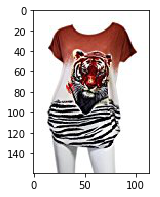

burnt umber tiger tshirt zebra stripes xl  xxl     euclidean distance = 0.0 
 Si Row 
 Brown 
 TOYS_AND_GAMES 
 *****************************************************************************************************************************

 All Recomendations :



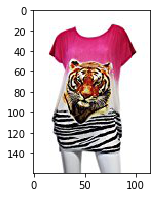

pink tiger tshirt zebra stripes xl  xxl     euclidean distance = 1.73205080757 
 Si Row 
 Pink 
 TOYS_AND_GAMES 
 *****************************************************************************************************************************



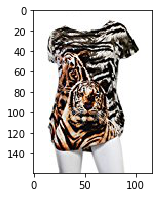

brown  white tiger tshirt tiger stripes xl  xxl     euclidean distance = 2.44948974278 
 Si Row 
 Brown 
 TOYS_AND_GAMES 
 *****************************************************************************************************************************



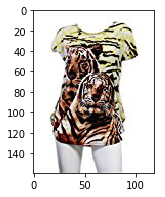

yellow tiger tshirt tiger stripes  l     euclidean distance = 2.64575131106 
 Si Row 
 Yellow 
 TOYS_AND_GAMES 
 *****************************************************************************************************************************



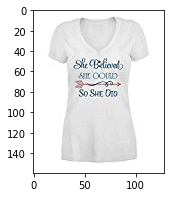

believed could tshirt     euclidean distance = 3.0 
 Rustic Grace 
 White 
 SHIRT 
 *****************************************************************************************************************************



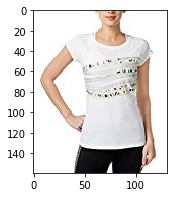

ideology graphic tshirt xl white     euclidean distance = 3.0 
 Ideology 
 White 
 SHIRT 
 *****************************************************************************************************************************



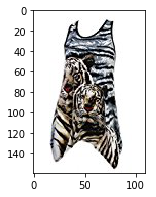

grey  white tiger tank top tiger stripes xl  xxl     euclidean distance = 3.0 
 Si Row 
 Grey 
 TOYS_AND_GAMES 
 *****************************************************************************************************************************



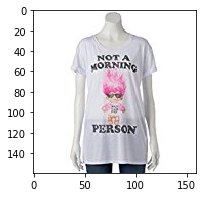

morning person tshirt  troll picture  xl     euclidean distance = 3.16227766017 
 Awake 
 White 
 SHIRT 
 *****************************************************************************************************************************



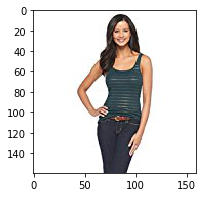

merona green gold stripes     euclidean distance = 3.16227766017 
 Merona 
 Green 
 SHIRT 
 *****************************************************************************************************************************



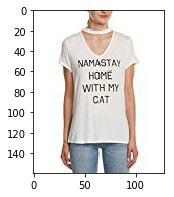

blvd womens graphic tshirt l     euclidean distance = 3.16227766017 
 BLVD 
 Ivory 
 SHIRT 
 *****************************************************************************************************************************



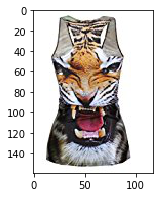

km tiger printed sleeveless vest tshirt     euclidean distance = 3.16227766017 
 KM T-shirt 
 Leopard 
 SHIRT 
 *****************************************************************************************************************************



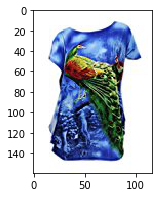

blue peacock print tshirt  l     euclidean distance = 3.16227766017 
 Si Row 
 Blue 
 TOYS_AND_GAMES 
 *****************************************************************************************************************************



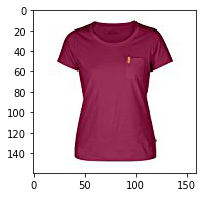

fjallraven  womens ovik tshirt plum xxl     euclidean distance = 3.16227766017 
 Fjallraven 
 Plum 
 SPORTING_GOODS 
 *****************************************************************************************************************************



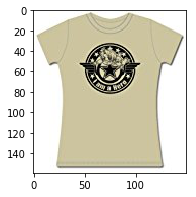

hetalia us girl tshirt     euclidean distance = 3.16227766017 
 Hetalia 
 Khaki 
 SHIRT 
 *****************************************************************************************************************************



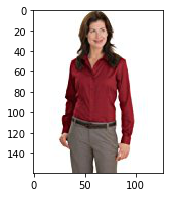

canvas 3001 30s tshirt  kelly  xl     euclidean distance = 3.16227766017 
 Red House 
 Deep Red 
 APPAREL 
 *****************************************************************************************************************************



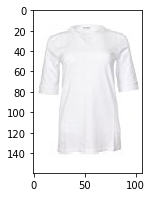

brunello cucinelli tshirt women white xl     euclidean distance = 3.16227766017 
 Brunello Cucinelli 
 White 
 SHIRT 
 *****************************************************************************************************************************



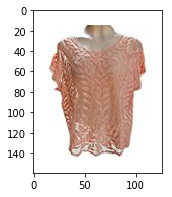

xhilaration womens lace tshirt salmon xxl     euclidean distance = 3.16227766017 
 Xhilaration 
 Salmon 
 SHIRT 
 *****************************************************************************************************************************



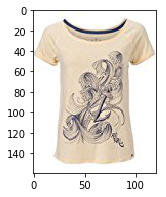

animal oceania tshirt  yellow     euclidean distance = 3.16227766017 
 Animal 
 Banana Yellow Marl 
 SHIRT 
 *****************************************************************************************************************************



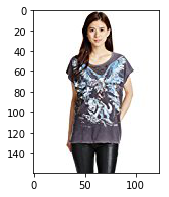

diesel tserraf tshirt black     euclidean distance = 3.16227766017 
 Diesel 
 Black 
 SHIRT 
 *****************************************************************************************************************************



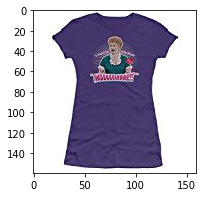

juniors love lucywaaaaahhhh tshirt size xl     euclidean distance = 3.16227766017 
 I Love Lucy 
 Purple 
 SHIRT 
 *****************************************************************************************************************************



In [116]:
# Calling the bagOfWords_model
doc_id = 12566
bagOfWords_model(doc_id, 20)

###### End of Bag Of Words

### 1.2. TF-IDF based Model

In [117]:
# Featurising using TF-IDF 
# Collecting feature matrix using tf-idf technique by TfidfVectorizer

# tf : term frequency of a word in a particular document defined as
# (#times a word appears in the document / total words in the document) 

# idf : inverse document frequency of a word in a given document corpus. Defined as 
# log(#documents in the corpus/#documents in the corpus containing the word)

tfidf_title_vectorizer = TfidfVectorizer()
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title']) 

# tfidf_title_features will be sparse matrix denoting the tfidf representation of each title. In tfidf, for each title we 
# build the sparse vector by storing the tf*idf values of each word that is present in the title. 
# This approach is better than the BOW since this accounts for word importance.

In [118]:
# Function to compute Euclidean Distances of the query product from the rest of the products.
# Euclidean distances will be based on the tfidf_title_features matrix obtained after TF-IDF approach on the title data. 

def tfidf_model(doc_id, num_results) :
    
    # Calculating pairwise euclidean distances using the tfidf features
    # returns a vector 
    pairwise_dist = pairwise_distances(tfidf_title_features, tfidf_title_features[doc_id])
    # Sort the pair wise distances and show results
    sort_and_showResults(pairwise_dist, num_results)

Query product :


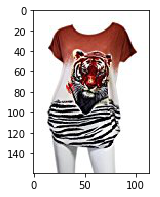

burnt umber tiger tshirt zebra stripes xl  xxl     euclidean distance = 0.0 
 Si Row 
 Brown 
 TOYS_AND_GAMES 
 *****************************************************************************************************************************

 All Recomendations :



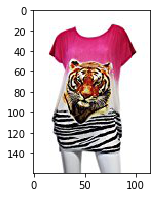

pink tiger tshirt zebra stripes xl  xxl     euclidean distance = 0.753633191245 
 Si Row 
 Pink 
 TOYS_AND_GAMES 
 *****************************************************************************************************************************



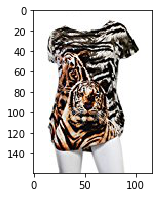

brown  white tiger tshirt tiger stripes xl  xxl     euclidean distance = 0.935764394377 
 Si Row 
 Brown 
 TOYS_AND_GAMES 
 *****************************************************************************************************************************



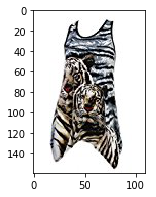

grey  white tiger tank top tiger stripes xl  xxl     euclidean distance = 0.95861535242 
 Si Row 
 Grey 
 TOYS_AND_GAMES 
 *****************************************************************************************************************************



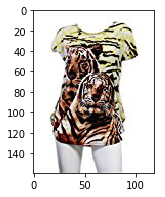

yellow tiger tshirt tiger stripes  l     euclidean distance = 1.00007496145 
 Si Row 
 Yellow 
 TOYS_AND_GAMES 
 *****************************************************************************************************************************



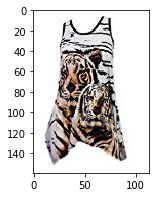

black  white tiger tank top tiger stripes  l     euclidean distance = 1.02321555246 
 Si Row 
 White 
 TOYS_AND_GAMES 
 *****************************************************************************************************************************



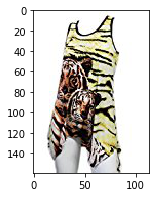

yellow tiger tank top tiger stripes  l     euclidean distance = 1.0319918463 
 Si Row 
 Yellow 
 TOYS_AND_GAMES 
 *****************************************************************************************************************************



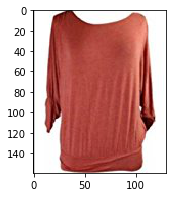

studio womens burnt orange dolman top size medium     euclidean distance = 1.21068436704 
 Studio M 
 Burnt Orange 
 SHIRT 
 *****************************************************************************************************************************



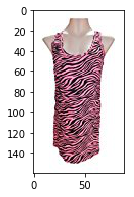

boundaries juniors racerback ribbed tank pink zebra xxl     euclidean distance = 1.21216838107 
 No Boundaries 
 Pink Zebra, 
 SHIRT 
 *****************************************************************************************************************************



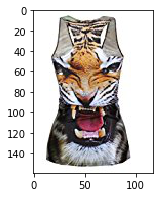

km tiger printed sleeveless vest tshirt     euclidean distance = 1.21979064028 
 KM T-shirt 
 Leopard 
 SHIRT 
 *****************************************************************************************************************************



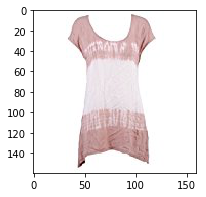

black swan estera raw umber l womens shirt     euclidean distance = 1.220684966 
 Black Swan 
 Raw Umber 
 SHIRT 
 *****************************************************************************************************************************



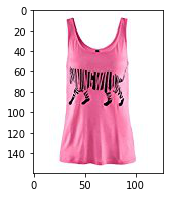

western zebra pattern sleeveless shirt vest tank tops pink xxl     euclidean distance = 1.22128139212 
 Black Temptation 
 Multicolored 
 BLAZER 
 *****************************************************************************************************************************



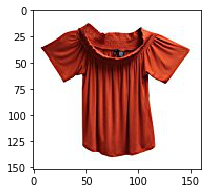

ultra flirt short sleeve shoulder blouse burnt red xs     euclidean distance = 1.23133640946 
 Ultra Flirt 
 Burnt Red 
 SHIRT 
 *****************************************************************************************************************************



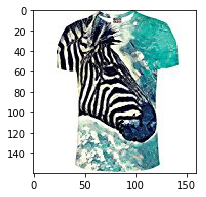

womens zebra watercolor tshirt  short sleeve  frontback print  xl     euclidean distance = 1.23184519726 
 WHAT ON EARTH 
 Multicolored 
 SHIRT 
 *****************************************************************************************************************************



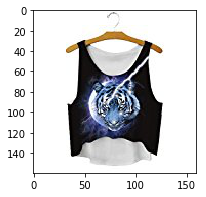

women fashion tiger printed black sleeveless crop top     euclidean distance = 1.23406074574 
 MKP Crop Top 
 Black, Blue 
 SHIRT 
 *****************************************************************************************************************************



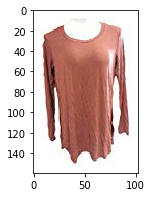

mossimo womens long sleeve side split top burnt orange medium     euclidean distance = 1.23527855777 
 Mossimo 
 Burnt Orange 
 SHIRT 
 *****************************************************************************************************************************



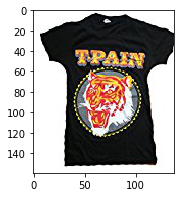

tpain tiger juniors tshirt size xlarge     euclidean distance = 1.23645729881 
 Tultex 
 Black 
 SHIRT 
 *****************************************************************************************************************************



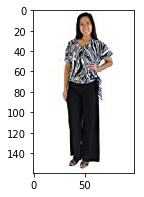

top  zebra print dolman sleeve top one size     euclidean distance = 1.24996155053 
 Vivian's Fashions 
 Black 
 SHIRT 
 *****************************************************************************************************************************



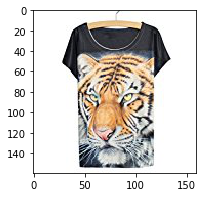

yichun womens tiger printed summer tshirts tops     euclidean distance = 1.25354614209 
 YICHUN 
 Multicoloured 
 SHIRT 
 *****************************************************************************************************************************



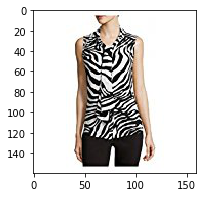

liz claiborne zebra fronttie top size xl     euclidean distance = 1.25388329384 
 Liz Claiborne 
 Crema Multi/Black 
 ACCESSORY 
 *****************************************************************************************************************************



In [49]:
# Calling the tfidf_model
doc_id = 12566
tfidf_model(doc_id, 20)

###### End of tf-idf based model 

### 1.3. IDF based Model

In [119]:
# Building idf vectorizer

# 1. build vocabulary using countvectorizer
idf_title_vectorizer = CountVectorizer() 
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

# idf_title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(corpus) returns a sparase matrix of dimensions #data_points * #words_in_corpus
# idf_title_features[doc_id, index_of_word_in_corpus] = number of times the word occured in that doc

In [120]:
# Function to calculate idf value of a word in the corpus
def getIDFvalue(word) :
    
    # #of_documents that have the given word
    numofDocs = sum(1 for doc in data['title'] if word in doc.split())
    return math.log(data.shape[0] / numofDocs) # returning the idf value

In [121]:
# Building the idf_title_features

idf_title_features  = idf_title_features.astype(np.float)

for word in idf_title_vectorizer.vocabulary_.keys() :
    
    # 2. For each word in the corpus, determine its idf value 
    idfValue = getIDFvalue(word)
    
    # idf_title_features[:, idf_title_vectorizer.vocabulary_[word]].nonzero()[0] this gives the list of all 
    # indices of the documents where word is present
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[word]].nonzero()[0] :
        
        # 3. Replace the values in the document term matrix with the idf values
        idf_title_features[j, idf_title_vectorizer.vocabulary_[word]] = idfValue
    

In [122]:
# Function to compute Euclidean Distances of the query product from the rest of the products.
# Euclidean distances will be based on the idf_title_features matrix obtained after IDF approach on the title data. 

def idf_model(doc_id, num_results) :
    
    # Calculating pairwise euclidean distances using the tfidf features
    # returns a vector (matrix of column 1).
    pairwise_dist = pairwise_distances(idf_title_features, idf_title_features[doc_id]) 
    # Sort the pair wise distances and show results
    sort_and_showResults(pairwise_dist, num_results)


Query product :


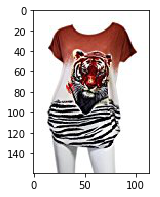

burnt umber tiger tshirt zebra stripes xl  xxl     euclidean distance = 0.0 
 Si Row 
 Brown 
 TOYS_AND_GAMES 
 *****************************************************************************************************************************

 All Recomendations :



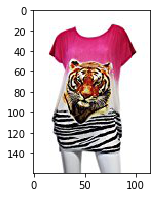

pink tiger tshirt zebra stripes xl  xxl     euclidean distance = 12.2050713112 
 Si Row 
 Pink 
 TOYS_AND_GAMES 
 *****************************************************************************************************************************



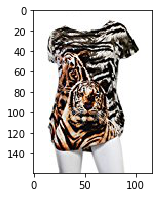

brown  white tiger tshirt tiger stripes xl  xxl     euclidean distance = 14.4683626856 
 Si Row 
 Brown 
 TOYS_AND_GAMES 
 *****************************************************************************************************************************



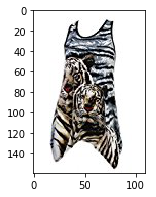

grey  white tiger tank top tiger stripes xl  xxl     euclidean distance = 14.4868329248 
 Si Row 
 Grey 
 TOYS_AND_GAMES 
 *****************************************************************************************************************************



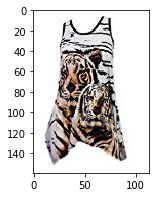

black  white tiger tank top tiger stripes  l     euclidean distance = 14.8333929667 
 Si Row 
 White 
 TOYS_AND_GAMES 
 *****************************************************************************************************************************



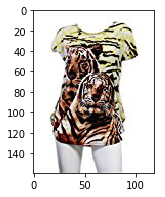

yellow tiger tshirt tiger stripes  l     euclidean distance = 14.8987445167 
 Si Row 
 Yellow 
 TOYS_AND_GAMES 
 *****************************************************************************************************************************



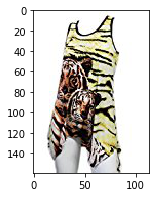

yellow tiger tank top tiger stripes  l     euclidean distance = 15.2244582873 
 Si Row 
 Yellow 
 TOYS_AND_GAMES 
 *****************************************************************************************************************************



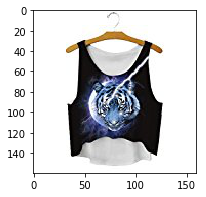

women fashion tiger printed black sleeveless crop top     euclidean distance = 17.0808129556 
 MKP Crop Top 
 Black, Blue 
 SHIRT 
 *****************************************************************************************************************************



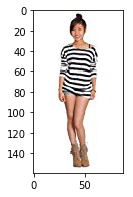

long sleeve top blouse tshirt     euclidean distance = 17.0901681256 
 Vietsbay 
 White 
 SHIRT 
 *****************************************************************************************************************************



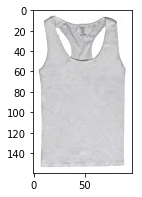

womens tank top  white     euclidean distance = 17.1532153376 
 Sofra 
 White 
 SHIRT 
 *****************************************************************************************************************************



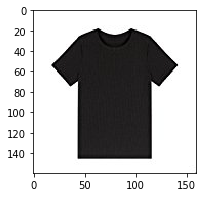

womens casual short sleeve tshirt     euclidean distance = 17.3367152387 
 Rain 
 Black 
 SHIRT 
 *****************************************************************************************************************************



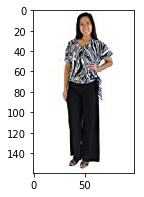

top  zebra print dolman sleeve top one size     euclidean distance = 17.410075941 
 Vivian's Fashions 
 Black 
 SHIRT 
 *****************************************************************************************************************************



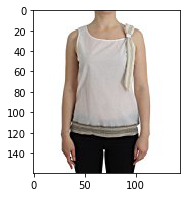

white top blouse tank shirt sleeveless     euclidean distance = 17.5399213355 
 ERMANNO SCERVINO 
 Multi 
 SHIRT 
 *****************************************************************************************************************************



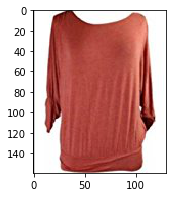

studio womens burnt orange dolman top size medium     euclidean distance = 17.6127585437 
 Studio M 
 Burnt Orange 
 SHIRT 
 *****************************************************************************************************************************



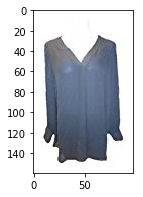

wear womens vneck blouse black xxl     euclidean distance = 17.6237452825 
 Who What Wear 
 Black 
 SHIRT 
 *****************************************************************************************************************************



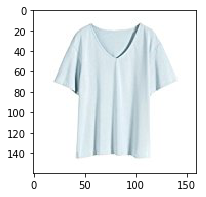

womens casual vneck short sleeve tshirt     euclidean distance = 17.6343424968 
 Rain 
 Cerulean 
 SHIRT 
 *****************************************************************************************************************************



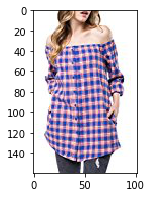

j womens shoulder blue small     euclidean distance = 17.6375371274 
 Very J 
 Blue 
 SHIRT 
 *****************************************************************************************************************************



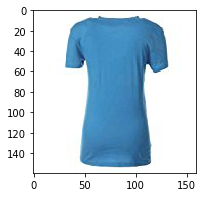

cotton tshirt womens fashion green     euclidean distance = 17.7230738913 
 Ivan Levi 
 Green 
 SHIRT 
 *****************************************************************************************************************************



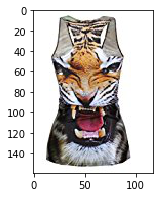

km tiger printed sleeveless vest tshirt     euclidean distance = 17.7625885612 
 KM T-shirt 
 Leopard 
 SHIRT 
 *****************************************************************************************************************************



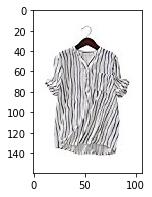

womens loose striped top blouse     euclidean distance = 17.7795368647 
 HP-LEISURE 
 dark blue and white stripes 
 SHIRT 
 *****************************************************************************************************************************



In [66]:
# Calling the idf_model
doc_id = 12566
idf_model(doc_id, 20)

###### End of idf based model

## 2. Text Semantics Based Product Similarity

<pre>
For taking into account the semantic relationship between the words while computing the euclidean distances, Word2Vec 
based models can be used to vectorize the words into a 300d dense vectors.

Since the original word2vec is too large, using the stripped down version available in the file word2vec_model that only contains vectors for words that are present in the current document corpus.

These word vectors can be combined together to form vectors for each title in the corpus.
2 Approaches for this :
    1. Average Word2Vec
    2. tf-ifdf based Word2Vec
</pre>

##### Loading the stripped down version of w2v model and functions to build title vectors by combining w2v vector of each word 

In [123]:
# load the model. model contains vectors for all the words in the corpus
with open('word2vec_model', 'rb') as handle:
    
    # model(type dict->'word' : vec) contains the 300-D dense vector for each word in our corpus
    model = pickle.load(handle) 

# vocab=list of all words in the corpus
vocab = model.keys() 

In [124]:
# Function to generate the feature vector for a given title using word2vec
def get_w2v_title(title, num_features, model_name, doc_id) :
    featureVec, num_words = np.zeros(shape=(num_features), dtype='float32'), 0
    # featureVec = np array to hold the title vector
    
    for word in title.split() :
        num_words += 1
        
        # ignoring the words that are not there in the vocab
        if word in vocab :
            if model_name == 'avg' :
                # Average w2v Model. (Simply adding up the word vecs and taking mean)
                
                featureVec = np.add(featureVec, model[word])
            
            elif model_name == 'weighted' and word in idf_title_vectorizer.vocabulary_.keys() :
                # Weighted w2v model (accounting for idf values and then taking mean) 
                
                idf_valOf_word = idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]]
                
                # Adding to featureVec, w2v vector of the word*idf value of the word
                featureVec = np.add(featureVec, model[word] * idf_valOf_word)
                
    if num_words :
        featureVec = np.divide(featureVec, num_words)
    return featureVec

# Function to generate feature matrix for the corpus using w2v
def get_w2v_titleFeatures(corpus, model_name) :
    w2v_titleFeatures, doc_id = [], 0
    # w2v_titleFeatures = list to hold the vectors for all the documents in the corpus
    # doc_id = index of the document in the corpus
    
    for doc in corpus :
        w2v_titleFeatures.append(get_w2v_title(doc, 300, model_name, doc_id))
        doc_id += 1
    return np.array(w2v_titleFeatures)

### 2.1. Average word2vec based Model

In [125]:
# Average Word2Vec
# Generating w2v features for the corpus
w2v_title_features = get_w2v_titleFeatures(data['title'], model_name='avg')

# Function to compute Euclidean Distances of the query product from the rest of the products.
# Euclidean distances will be based on the w2v_title_features matrix obtained after 
# w2v approach on the title data. 
def avg_w2v_model(doc_id, num_results) :
    
    # Calculating pairwise euclidean distances using the w2v title features
    pairwise_dist = pairwise_distances(w2v_title_features, w2v_title_features[doc_id].reshape(1, -1)) 
    # Sort the pair wise distances and show results
    sort_and_showResults(pairwise_dist, num_results)

Query product :


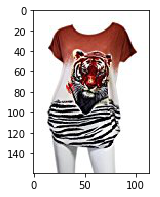

burnt umber tiger tshirt zebra stripes xl  xxl     euclidean distance = 0.000690534 
 Si Row 
 Brown 
 TOYS_AND_GAMES 
 *****************************************************************************************************************************

 All Recomendations :



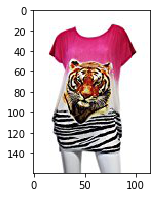

pink tiger tshirt zebra stripes xl  xxl     euclidean distance = 0.589193 
 Si Row 
 Pink 
 TOYS_AND_GAMES 
 *****************************************************************************************************************************



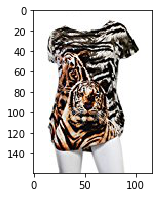

brown  white tiger tshirt tiger stripes xl  xxl     euclidean distance = 0.700344 
 Si Row 
 Brown 
 TOYS_AND_GAMES 
 *****************************************************************************************************************************



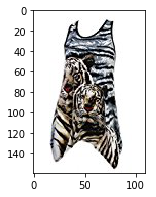

grey  white tiger tank top tiger stripes xl  xxl     euclidean distance = 0.89284 
 Si Row 
 Grey 
 TOYS_AND_GAMES 
 *****************************************************************************************************************************



In [55]:
# Calling the avg_w2v_model
doc_id = 12566
avg_w2v_model(doc_id, 4)

###### End of average word2vec

### 2.2. IDF weighted Word2Vec Model 

In [126]:
# Weighted Word2Vec
# Generating weighted w2v features for the corpus
weighted_w2v_title_features = get_w2v_titleFeatures(data['title'], model_name='weighted')

# Function to compute Euclidean Distances of the query product from the rest of the products.
# Euclidean distances will be based on the weighted_w2v_title_features matrix obtained after 
# weighted w2v approach on the title data. 
def weighted_w2v_model(doc_id, num_results) :
    
    # Calculating pairwise euclidean distances using the w2v title features
    pairwise_dist = pairwise_distances(weighted_w2v_title_features, weighted_w2v_title_features[doc_id].reshape(1, -1)) 
    # Sort the pair wise distances and show results
    sort_and_showResults(pairwise_dist, num_results)

Query product :


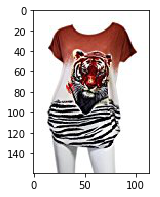

burnt umber tiger tshirt zebra stripes xl  xxl     euclidean distance = 0.00390625 
 Si Row 
 Brown 
 TOYS_AND_GAMES 
 *****************************************************************************************************************************

 All Recomendations :



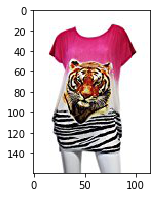

pink tiger tshirt zebra stripes xl  xxl     euclidean distance = 2.52446 
 Si Row 
 Pink 
 TOYS_AND_GAMES 
 *****************************************************************************************************************************



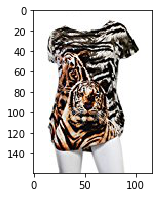

brown  white tiger tshirt tiger stripes xl  xxl     euclidean distance = 3.8621 
 Si Row 
 Brown 
 TOYS_AND_GAMES 
 *****************************************************************************************************************************



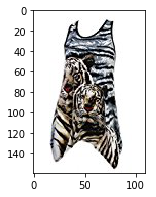

grey  white tiger tank top tiger stripes xl  xxl     euclidean distance = 4.23536 
 Si Row 
 Grey 
 TOYS_AND_GAMES 
 *****************************************************************************************************************************



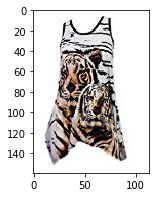

black  white tiger tank top tiger stripes  l     euclidean distance = 4.74897 
 Si Row 
 White 
 TOYS_AND_GAMES 
 *****************************************************************************************************************************



In [57]:
# Calling the weighted_w2v_model
doc_id = 12566
weighted_w2v_model(doc_id, 5)

###### End of idf weighted word2vec based Model

## 3. Weighted Similarity Using brand and color Features

In [127]:
# Replacing Null values with Notgiven
data['brand'].fillna(value="Not given", inplace=True)

# Replacing spaces with hyphens
brands = [x.replace(' ', '-') for x in data['brand'].values]
types = [x.replace(' ', '-') for x in data['product_type_name'].values]
colors = [x.replace(' ', '-') for x in data['color'].values]

# marking onehot encoding 
# sparse vectors
brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

# Stacking the three additional features together
extra_features = hstack((brand_features, type_features, color_features)).tocsr()

In [128]:
# Function to compute Euclidean Distances of the query product from the rest of the products.
# These Euclidean distances will be based on the weighted_w2v_title_features matrix along that we obtained after 
# weighted w2v approach on the title data along with the extra features stacked together using onehot encoding
def weighted_w2v_extra_model(doc_id, num_results, wt, we) :
    
    # Calculating pairwise euclidean distances using the w2v title features
    idf_pairwise_dist = pairwise_distances(weighted_w2v_title_features, weighted_w2v_title_features[doc_id].reshape(1, -1)) 
    
    # Calculating pairwise euclidean distances using the extra features
    extra_pairwise_dist = pairwise_distances(extra_features, extra_features[doc_id])
    
    # Calculating pairwise distances by combining the w2v title distance with its weight and extra features with its weight
    pairwise_dist = (wt * idf_pairwise_dist + we * extra_pairwise_dist) / float(wt + we)
    
    # Sort the pair wise distances and show results
    sort_and_showResults(pairwise_dist, num_results)

Query product :


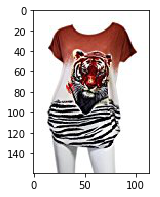

burnt umber tiger tshirt zebra stripes xl  xxl     euclidean distance = 0.001953125 
 Si Row 
 Brown 
 TOYS_AND_GAMES 
 *****************************************************************************************************************************

 All Recomendations :



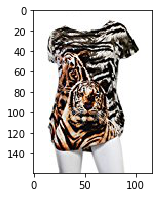

brown  white tiger tshirt tiger stripes xl  xxl     euclidean distance = 1.9310508728 
 Si Row 
 Brown 
 TOYS_AND_GAMES 
 *****************************************************************************************************************************



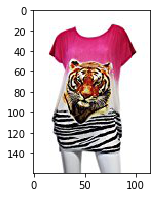

pink tiger tshirt zebra stripes xl  xxl     euclidean distance = 1.96933860797 
 Si Row 
 Pink 
 TOYS_AND_GAMES 
 *****************************************************************************************************************************



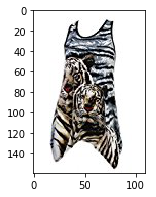

grey  white tiger tank top tiger stripes xl  xxl     euclidean distance = 2.82478828448 
 Si Row 
 Grey 
 TOYS_AND_GAMES 
 *****************************************************************************************************************************



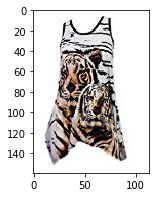

black  white tiger tank top tiger stripes  l     euclidean distance = 3.08159198779 
 Si Row 
 White 
 TOYS_AND_GAMES 
 *****************************************************************************************************************************



In [60]:
# Calling the weighted_w2v_extra_model
doc_id = 12566
weighted_w2v_extra_model(doc_id, 5, 5, 5)

## 4. Visual Similarity Based Model

In [129]:
#load the features and corresponding ASINS info.
bottleneck_features_train = np.load('16k_data_cnn_features.npy')
asins = np.load('16k_data_cnn_feature_asins.npy')
asins = list(asins)

# load the original 16K dataset
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
df_asins = list(data['asin'])

from IPython.display import display, Image, SVG, Math, YouTubeVideo

#get similar products using CNN features (VGG-16)
def get_similar_products_cnn(doc_id, num_results):
    doc_id = asins.index(df_asins[doc_id])
    pairwise_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    for i in range(len(indices)):
        rows = data[['medium_image_url','title']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title: ', row['title'])
            print('Euclidean Distance from input image:', pdists[i])
            print('Amazon Url: www.amzon.com/dp/'+ asins[indices[i]])

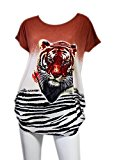

Product Title:  burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 0.0625
Amazon Url: www.amzon.com/dp/B00JXQB5FQ


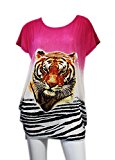

Product Title:  pink tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 30.0501
Amazon Url: www.amzon.com/dp/B00JXQASS6


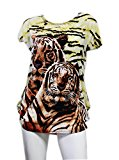

Product Title:  yellow tiger tshirt tiger stripes  l 
Euclidean Distance from input image: 41.2611
Amazon Url: www.amzon.com/dp/B00JXQCUIC


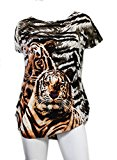

Product Title:  brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean Distance from input image: 44.0002
Amazon Url: www.amzon.com/dp/B00JXQCWTO


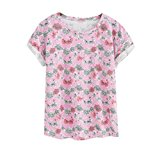

Product Title:  kawaii pastel tops tees pink flower design 
Euclidean Distance from input image: 47.3825
Amazon Url: www.amzon.com/dp/B071FCWD97


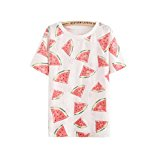

Product Title:  womens thin style tops tees pastel watermelon print 
Euclidean Distance from input image: 47.7184
Amazon Url: www.amzon.com/dp/B01JUNHBRM


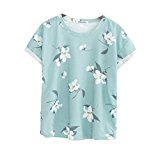

Product Title:  kawaii pastel tops tees baby blue flower design 
Euclidean Distance from input image: 47.9021
Amazon Url: www.amzon.com/dp/B071SBCY9W


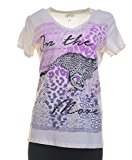

Product Title:  edv cheetah run purple multi xl 
Euclidean Distance from input image: 48.0465
Amazon Url: www.amzon.com/dp/B01CUPYBM0


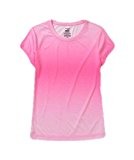

Product Title:  danskin womens vneck loose performance tee xsmall pink ombre 
Euclidean Distance from input image: 48.1019
Amazon Url: www.amzon.com/dp/B01F7PHXY8


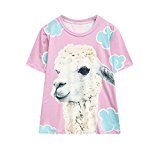

Product Title:  summer alpaca 3d pastel casual loose tops tee design 
Euclidean Distance from input image: 48.1189
Amazon Url: www.amzon.com/dp/B01I80A93G


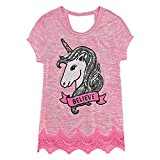

Product Title:  miss chievous juniors striped peplum tank top medium shadowpeach 
Euclidean Distance from input image: 48.1313
Amazon Url: www.amzon.com/dp/B0177DM70S


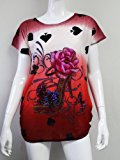

Product Title:  red  pink floral heel sleeveless shirt xl  xxl 
Euclidean Distance from input image: 48.1695
Amazon Url: www.amzon.com/dp/B00JV63QQE


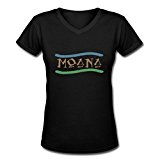

Product Title:  moana logo adults hot v neck shirt black xxl 
Euclidean Distance from input image: 48.2568
Amazon Url: www.amzon.com/dp/B01LX6H43D


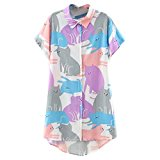

Product Title:  abaday multicolor cartoon cat print short sleeve longline shirt large 
Euclidean Distance from input image: 48.2656
Amazon Url: www.amzon.com/dp/B01CR57YY0


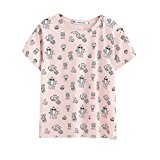

Product Title:  kawaii cotton pastel tops tees peach pink cactus design 
Euclidean Distance from input image: 48.3626
Amazon Url: www.amzon.com/dp/B071WYLBZS


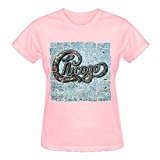

Product Title:  chicago chicago 18 shirt women pink 
Euclidean Distance from input image: 48.3836
Amazon Url: www.amzon.com/dp/B01GXAZTRY


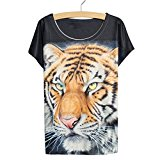

Product Title:  yichun womens tiger printed summer tshirts tops 
Euclidean Distance from input image: 48.4493
Amazon Url: www.amzon.com/dp/B010NN9RXO


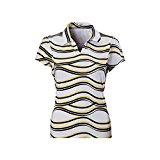

Product Title:  nancy lopez whimsy short sleeve  whiteblacklemon drop  xs 
Euclidean Distance from input image: 48.4789
Amazon Url: www.amzon.com/dp/B01MPX6IDX


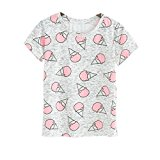

Product Title:  womens tops tees pastel peach ice cream cone print 
Euclidean Distance from input image: 48.558
Amazon Url: www.amzon.com/dp/B0734GRKZL


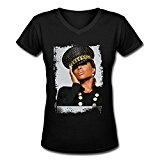

Product Title:  uswomens mary j blige without tshirts shirt 
Euclidean Distance from input image: 48.6144
Amazon Url: www.amzon.com/dp/B01M0XXFKK


In [5]:
# calling visual model
get_similar_products_cnn(12566, 20)

________________________________________________________________________________________________________________________________
## Model based on weighted idf-w2v features, brand, color and image features

In [130]:
def weighted_multiple_variable_model(doc_id, num_results, w):
    
    # Using idf-w2v features, brand features, color features and image features
    # Weight for idf-w2v -> w[0], brand features -> w[1], color features -> w[2], image features -> w[3]
    
    idf_pairwise_dist = pairwise_distances(weighted_w2v_title_features, weighted_w2v_title_features[doc_id].reshape(1, -1))
    
    brand_pairwise_dist = pairwise_distances(brand_features, brand_features[doc_id])
    
    color_pairwise_dist = pairwise_distances(color_features, color_features[doc_id])
    
    doc_id = asins.index(df_asins[doc_id])
    img_pairwise_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))
    
    pairwise_dist = (w[0]*idf_pairwise_dist+ w[1]*brand_pairwise_dist+w[2]*color_pairwise_dist+w[3]*img_pairwise_dist)/float(sum(w))

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    for i in range(len(indices)):
        rows = data[['medium_image_url','title']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title: ', row['title'])
            print('Euclidean Distance from input image:', pdists[i])
            print('Amazon Url: www.amzon.com/dp/'+ asins[indices[i]])


In [131]:
# Weights for the various features
weights = [10, 10, 10, 10]
# [0] -> idfw2v features
# [1] -> brand featrues
# [2] -> color features
# [3] -> images features

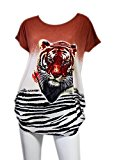

Product Title:  burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 2.80311856632
Amazon Url: www.amzon.com/dp/B00JXQB5FQ


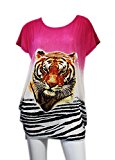

Product Title:  pink tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 10.5444842968
Amazon Url: www.amzon.com/dp/B00JXQASS6


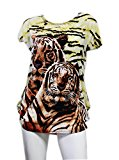

Product Title:  yellow tiger tshirt tiger stripes  l 
Euclidean Distance from input image: 12.9689905167
Amazon Url: www.amzon.com/dp/B00JXQCUIC


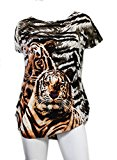

Product Title:  brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean Distance from input image: 13.864992835
Amazon Url: www.amzon.com/dp/B00JXQCWTO


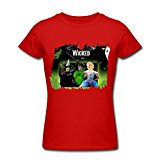

Product Title:  womans wicked musical poster shirts red xxl 
Euclidean Distance from input image: 14.4784580232
Amazon Url: www.amzon.com/dp/B01KUN4VWE


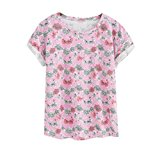

Product Title:  kawaii pastel tops tees pink flower design 
Euclidean Distance from input image: 14.7317285576
Amazon Url: www.amzon.com/dp/B071FCWD97


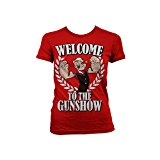

Product Title:  officially licensed merchandise popeye  welcome gunshow girly tshirt red xxlarge 
Euclidean Distance from input image: 14.7511487961
Amazon Url: www.amzon.com/dp/B01BFLPAK2


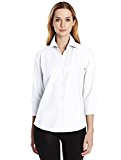

Product Title:  foxcroft nyc womens pinpoint oxford shirt noniron stretch poplin blouse xlarge white 
Euclidean Distance from input image: 14.7665359497
Amazon Url: www.amzon.com/dp/B072277HVB


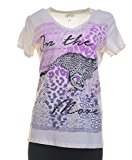

Product Title:  edv cheetah run purple multi xl 
Euclidean Distance from input image: 14.7845752716
Amazon Url: www.amzon.com/dp/B01CUPYBM0


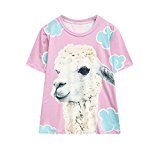

Product Title:  summer alpaca 3d pastel casual loose tops tee design 
Euclidean Distance from input image: 14.7919551152
Amazon Url: www.amzon.com/dp/B01I80A93G


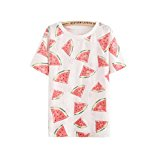

Product Title:  womens thin style tops tees pastel watermelon print 
Euclidean Distance from input image: 14.8326828004
Amazon Url: www.amzon.com/dp/B01JUNHBRM


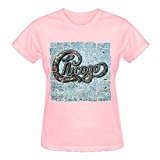

Product Title:  chicago chicago 18 shirt women pink 
Euclidean Distance from input image: 14.8462935007
Amazon Url: www.amzon.com/dp/B01GXAZTRY


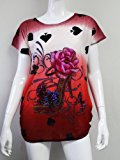

Product Title:  red  pink floral heel sleeveless shirt xl  xxl 
Euclidean Distance from input image: 14.8763639451
Amazon Url: www.amzon.com/dp/B00JV63QQE


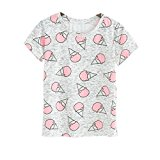

Product Title:  womens tops tees pastel peach ice cream cone print 
Euclidean Distance from input image: 14.8821254731
Amazon Url: www.amzon.com/dp/B0734GRKZL


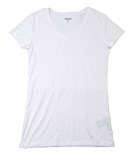

Product Title:  kirkland signature ladies size medium cotton vneck tee white 
Euclidean Distance from input image: 14.8881427766
Amazon Url: www.amzon.com/dp/B073ZRD5FL


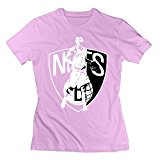

Product Title:  vansty jeremy lin brooklin short sleeves shirt women pink size 
Euclidean Distance from input image: 14.9039491653
Amazon Url: www.amzon.com/dp/B01HU4NSBQ


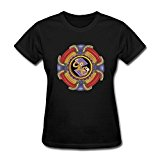

Product Title:  dasy womens neck electric light orchestra logo shirt xxlarge black 
Euclidean Distance from input image: 14.9136180181
Amazon Url: www.amzon.com/dp/B016EXUZC4


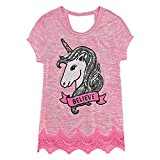

Product Title:  miss chievous juniors striped peplum tank top medium shadowpeach 
Euclidean Distance from input image: 14.9196468354
Amazon Url: www.amzon.com/dp/B0177DM70S


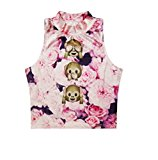

Product Title:  kingde star pink flower dog stamp sleeveless vestbqn24 
Euclidean Distance from input image: 14.9643424292
Amazon Url: www.amzon.com/dp/B015H3W9BM


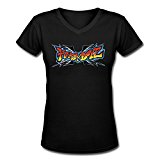

Product Title:  cling womens hardy boyz wwe logo vneck tshirt black 
Euclidean Distance from input image: 14.9728847505
Amazon Url: www.amzon.com/dp/B01A82FFBI


In [133]:
# Calling weighted_multiple_variable_model
# With equal weights to all four
weighted_multiple_variable_model(12566, 20, weights)

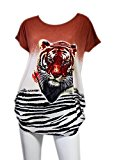

Product Title:  burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 3.5171638024
Amazon Url: www.amzon.com/dp/B00JXQB5FQ


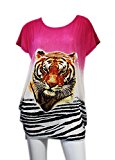

Product Title:  pink tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 16.1802925638
Amazon Url: www.amzon.com/dp/B00JXQASS6


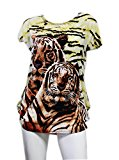

Product Title:  yellow tiger tshirt tiger stripes  l 
Euclidean Distance from input image: 20.6149848938
Amazon Url: www.amzon.com/dp/B00JXQCUIC


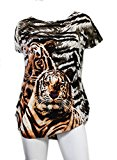

Product Title:  brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean Distance from input image: 22.0595662203
Amazon Url: www.amzon.com/dp/B00JXQCWTO


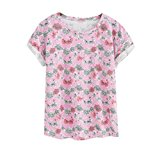

Product Title:  kawaii pastel tops tees pink flower design 
Euclidean Distance from input image: 23.3361201617
Amazon Url: www.amzon.com/dp/B071FCWD97


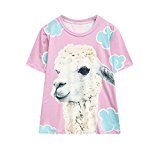

Product Title:  summer alpaca 3d pastel casual loose tops tee design 
Euclidean Distance from input image: 23.4092410809
Amazon Url: www.amzon.com/dp/B01I80A93G


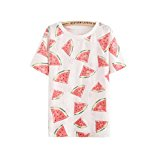

Product Title:  womens thin style tops tees pastel watermelon print 
Euclidean Distance from input image: 23.5830671947
Amazon Url: www.amzon.com/dp/B01JUNHBRM


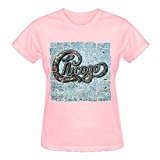

Product Title:  chicago chicago 18 shirt women pink 
Euclidean Distance from input image: 23.5891219628
Amazon Url: www.amzon.com/dp/B01GXAZTRY


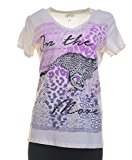

Product Title:  edv cheetah run purple multi xl 
Euclidean Distance from input image: 23.640960439
Amazon Url: www.amzon.com/dp/B01CUPYBM0


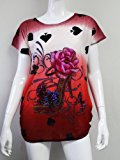

Product Title:  red  pink floral heel sleeveless shirt xl  xxl 
Euclidean Distance from input image: 23.6558696747
Amazon Url: www.amzon.com/dp/B00JV63QQE


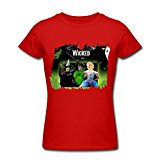

Product Title:  womans wicked musical poster shirts red xxl 
Euclidean Distance from input image: 23.6593593598
Amazon Url: www.amzon.com/dp/B01KUN4VWE


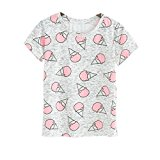

Product Title:  womens tops tees pastel peach ice cream cone print 
Euclidean Distance from input image: 23.6654707591
Amazon Url: www.amzon.com/dp/B0734GRKZL


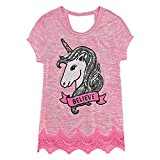

Product Title:  miss chievous juniors striped peplum tank top medium shadowpeach 
Euclidean Distance from input image: 23.7280066173
Amazon Url: www.amzon.com/dp/B0177DM70S


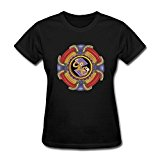

Product Title:  dasy womens neck electric light orchestra logo shirt xxlarge black 
Euclidean Distance from input image: 23.8072756217
Amazon Url: www.amzon.com/dp/B016EXUZC4


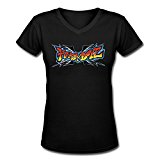

Product Title:  cling womens hardy boyz wwe logo vneck tshirt black 
Euclidean Distance from input image: 23.816735967
Amazon Url: www.amzon.com/dp/B01A82FFBI


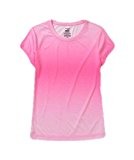

Product Title:  danskin womens vneck loose performance tee xsmall pink ombre 
Euclidean Distance from input image: 23.8252548866
Amazon Url: www.amzon.com/dp/B01F7PHXY8


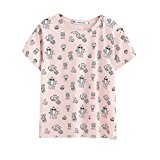

Product Title:  kawaii cotton pastel tops tees peach pink cactus design 
Euclidean Distance from input image: 23.828752964
Amazon Url: www.amzon.com/dp/B071WYLBZS


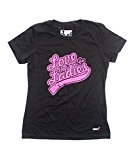

Product Title:  new balance womens blackpink love ladies shirt us small 
Euclidean Distance from input image: 23.8679657631
Amazon Url: www.amzon.com/dp/B071ZM3N95


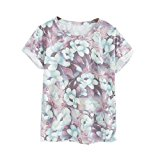

Product Title:  kawaii cotton pastel tops tees pink flower design 
Euclidean Distance from input image: 23.8787311554
Amazon Url: www.amzon.com/dp/B071P4YKH5


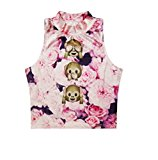

Product Title:  kingde star pink flower dog stamp sleeveless vestbqn24 
Euclidean Distance from input image: 23.891814908
Amazon Url: www.amzon.com/dp/B015H3W9BM


In [134]:
# More weight to title and image
weights[0], weights[3] = 50, 50
weighted_multiple_variable_model(12566, 20, weights)